## Libraries

In [12]:
from datetime import datetime
import numpy as np
import pandas as pd
import requests
from enum import Enum
import warnings as wrn
import matplotlib.pyplot as plt

class ActionType(Enum):
    BUY = 1
    DONOTHING = 0
    SELL = -1

#### Function to make an API call to Binance

In [13]:
def make_api_call(base_url, endpoint="", method="GET", **kwargs):
    # Construct the full URL
    full_url = f'{base_url}{endpoint}'

    # Make the API call
    response = requests.request(method=method, url=full_url, **kwargs)

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        return response
    else:
        # If the request was not successful, raise an exception with the error message
        raise Exception(f'API request failed with status code {response.status_code}: {response.text}')

In [14]:
def get_binance_historical_data(symbol, interval, start_date, end_date):
    
    # define basic parameters for call
    base_url = 'https://fapi.binance.com'
    endpoint = '/fapi/v1/klines'
    method = 'GET'
    
    # Set the start time parameter in the params dictionary
    params = {
        'symbol': symbol,
        'interval': interval,
        'limit': 1500,
        'startTime': start_date, # Start time in milliseconds
        'endTime': end_date # end time in milliseconds
    }

    # Make initial API call to get candles
    response = make_api_call(base_url, endpoint=endpoint, method=method, params=params)
    
    # initalize candles data
    candles_data = []

    # Append the received candles to the list
    candles_data.extend(response.json())

    # Update the start time for the next API call
    params['startTime'] = candles_data[-1][0] + 1 # last candle open_time + 1ms    

    while len(response.json()) > 0:
        # Make the next API call
        response = make_api_call(base_url, endpoint=endpoint, method=method, params=params)

        # Append the received candles to the list
        candles_data.extend(response.json())

        # Update the start time for the next API call
        params['startTime'] = candles_data[-1][0] + 1 # last candle open_time + 1ms
        
        if params['startTime'] > params['endTime']:
            break

    # Wrap the candles data as a pandas DataFrame
    columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume',
               'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore']
    dtype={
    'open_time': 'datetime64[ms, Asia/Jerusalem]',
    'open': 'float64',
    'high': 'float64',
    'low': 'float64',
    'close': 'float64',
    'volume': 'float64',
    'close_time': 'datetime64[ms, Asia/Jerusalem]',
    'quote_asset_volume': 'float64',
    'number_of_trades': 'int64',
    'taker_buy_base_asset_volume': 'float64',
    'taker_buy_quote_asset_volume': 'float64',
    'ignore': 'float64'
    }
    
    df = pd.DataFrame(candles_data, columns=columns)
    df = df.astype(dtype)

    return df

### 2. Getting the data

In [15]:
symbol = 'BTCUSDT'
interval = '30m'
start_date = int(datetime(year=2023, month=1, day=1).timestamp() * 1000)
end_date = int(datetime(year=2024, month=1, day=1).timestamp() * 1000)

btcusdt_df = get_binance_historical_data(symbol, interval, start_date, end_date)[['open_time', 'open', 'high', 'low', 'close', 'volume']]
btcusdt_df

,open_time,open,high,low,close,volume
0,2023-01-01 00:00:00+02:00,16544.0,16565.1,16496.0,16540.7,7737.533
1,2023-01-01 00:30:00+02:00,16540.8,16550.8,16461.8,16515.1,8929.034
2,2023-01-01 01:00:00+02:00,16515.1,16524.6,16483.1,16520.9,5215.713
3,2023-01-01 01:30:00+02:00,16520.9,16546.9,16516.5,16537.6,3127.373
4,2023-01-01 02:00:00+02:00,16537.5,16540.9,16513.4,16539.4,2832.734
...,...,...,...,...,...,...
17516,2023-12-31 22:00:00+02:00,42659.9,42724.5,42600.0,42627.2,2559.181
17517,2023-12-31 22:30:00+02:00,42627.2,42662.5,42543.3,42599.1,2171.755
17518,2023-12-31 23:00:00+02:00,42599.2,42717.0,42586.7,42674.8,1468.758
17519,2023-12-31 23:30:00+02:00,42674.8,42689.1,42558.2,42558.9,2325.252


### 3. Calculate the indicators

## **UTBot**
### **The Logic Behind it:**
The UTBot indicator is more carefull in it's signals overall the higher the key value is.
* The key value is setting the overall size of the threshold, the higher the key value the greater the threshold is, and accordingly it is harder for the trailing stop to change.

    that is because when the threshold is bigger, the trailing stop doesnt change unless the current close is greater than the previous trailing stop and the previous close is smaller than the previous trailing stop, or the opposite.

    when both the current and the previous close are greater than the previous trailing stop or smaller than it the trailing stop can only will change only if the difference between the current close and the previous close is greater than the current threshold.

    and when the key value is greater the threshold becomes greater aswell.

The UTBot indicator is more carefull in it's signals over the passing of time the longer the ATR Period is set.
* The ATR Period is setting the weakening of the effect each TR value has on the threshold, meaning the more the TR values "agree" with each other, the more representetive the ATR value of the TRs' values.

    from this comes to play how does this value affect the threshold, the more there are TR values that are greater, the higher the threshold, and the same applys for when the there are more TR values that are smaller.

    over time the threshold changes less speratically the greater the ATR Period because there are more TR values to keep the ATR and the threshold values similar to their previous values.

    in other words the threshold is more stable over time when the longer the ATR Period is.

in the video there are 2 UTBot indictors used, both have the same key value, but the indicator that gives the Buy signal is more carefull than the indicator that gives the Sell signal when it "decides" to give the signal.

this means that to give a Buy signal the indicators wait for longer than for giving a Sell signal, once there is some slight loss you should Sell but when there is there some gain you should wait and see if this gain is consistent enough.

Simply put, this indicator finds relatively safe opportunities to perform Buy and Sell signals

### **How it works:**
1. Calculate the $TR_t$ for every sample $t$ in the data.

    **TR Formula:** $\;\:TR_t = \max\{High_t,\;Close_{t-1}\} - \min\{Low_t,\;Close_{t-1}\}$

2. Calculate using the $TR_t$ the $ATR_t$ for every sample $t$ in the data relative to the set $ATR\,\:Period$ ($n$ in the formula).

    **ATR Formula:** $\;\:ATR_t=\sum_{i=0}^{n-1}\frac{TR_{t-i}}{n}$

3. Calculate using the $ATR_t$ the $LossThreshold_t$ for every sample $t$ in the data relative to the set $KeyVal$.

    **Loss Threshold Formula:** $\;\:LossThreshold_t = KeyVal \times ATR_t$

4. Set $TrailingStop_{\,0} = 0$

5. Find the $TrailingStop_{t}$ of for every sample $t$ in the data (not including $0$) in accordance to the following rules:
    * When $Close_t>TrailingStop_{t-1}\;$ **&** $\;Close_{t-1}>TrailingStop_{t-1}$:
    $$TrailingStop_t = \max\{TrailingStop_{t-1},\;Close_t - LossThreshold_t\}$$
    * When $Close_t<TrailingStop_{t-1}\;$ **&** $\;Close_{t-1}<TrailingStop_{t-1}$:
    $$TrailingStop_t = \min\{TrailingStop_{t-1},\;Close_t + LossThreshold_t\}$$
    * When $Close_t>TrailingStop_{t-1}\;$ **&** $\;Close_{t-1}<TrailingStop_{t-1}$:
    $$TrailingStop_t = close_t - LossThreshold_t$$
    * In any other case:
    $$TrailingStop_t = close_t + LossThreshold_t$$

6. Set the signals in accordance to the following rules:
    * When $close_t>TrailingStop_t\;$ **&** $\;Close_{t-1}<TrailingStop_{t-1}$ set $Signal_t = Buy$
    * When $close_t<TrailingStop_t\;$ **&** $\;Close_{t-1}>TrailingStop_{t-1}$ set $Signal_t = Sell$
    * In any other case set $Signal_t = DoNothing$

#### Helper Functions

In [16]:
def TR(close: pd.Series, high: pd.Series, low: pd.Series) -> pd.Series:
    return (high.where(high > close.shift(1), close.shift(1)) - low.where(low < close.shift(1), close.shift(1)))

def ATR(TRsrs: pd.Series, atr_length: int) -> pd.Series:
    return TRsrs.rolling(window = atr_length).mean()

def crossOver(a: pd.Series, b: pd.Series) -> pd.Series:
    return (a > b) & (a.shift(1) < b.shift(1))

##### Main Function

Because the presentor used 2 UTBot indicators we decided to make the UTBot implementation a little more customizable

Here the default settings are the same as the presentor has set in the video

In [17]:
def UTBot(close, high, low, buyKeyVal = 2, buyATRlen = 300, sellKeyVal = 2, sellATRlen = 1) -> pd.Series:
    # Steps 1, 2 and 3
    lossThrshBuy = buyKeyVal * ATR(TR(close, high, low), buyATRlen)
    lossThrshSell = sellKeyVal * ATR(TR(close, high, low), sellATRlen)
    trailStopBuy = 0 * lossThrshBuy
    trailStopSell = 0 * lossThrshSell

    # Step 4
    for i in range(1, len(trailStopBuy)):
        # the previous buy trailing stop is lower than the current and previous close
        if (close[i] > trailStopBuy[i - 1]) & (close[i - 1] > trailStopBuy[i - 1]):
            trailStopBuy[i] = max(trailStopBuy[i - 1], close[i] - lossThrshBuy[i])
        # the previous buy trailing stop is higher than the current and previous close
        elif (close[i] < trailStopBuy[i - 1]) & (close[i - 1] < trailStopBuy[i - 1]):
            trailStopBuy[i] = min(trailStopBuy[i - 1], close[i] + lossThrshBuy[i])
        # the previous buy trailing stop is lower than the current close and higher than the previous close
        elif (close[i] > trailStopBuy[i - 1]):
            trailStopBuy[i] = close[i] - lossThrshBuy[i]
        # the previous buy trailing stop is higher than the current close and lower than the previous close
        else:
            trailStopBuy[i] = close[i] + lossThrshBuy[i]
        
        # the same for the sell trailing stop
        if (close[i] > trailStopSell[i - 1]) & (close[i - 1] > trailStopSell[i - 1]):
            trailStopSell[i] = max(trailStopSell[i - 1], close[i] - lossThrshSell[i])
        elif (close[i] < trailStopSell[i - 1]) & (close[i - 1] < trailStopSell[i - 1]):
            trailStopSell[i] = min(trailStopSell[i - 1], close[i] - lossThrshSell[i])
        elif (close[i] > trailStopSell[i - 1]):
            trailStopSell[i] = close[i] - lossThrshSell[i]
        else:
            trailStopSell[i] = close[i] + lossThrshSell[i]

    # Step 5
    above = crossOver(close, trailStopBuy)
    below = crossOver(trailStopSell, close)

    # Step 6
    Action = np.select([above, below], [ActionType.BUY, ActionType.SELL], default = ActionType.DONOTHING)
    
    return Action

## STC Osilator
### The Logic Behind it:
The STC Osilator relys on the difference between the short-term $EMA$ ($FastEMA$) and the long-term $EMA$ ($SlowEMA$)

Each $EMA$ for period $n$ at time $t$ is calculated: $$EMA_t^n = (close_t - EMA_{t-1}^n)\times\frac{Constant}{1+n} + EMA_{t-1}^n$$

Where $$EMA_{\,n-1}^n=SMA_{n-1}^n=\sum_{i=0}^{n-1}\frac{Close_{t-i}}{n}$$

and $\frac{Constant}{1+n}$ is set (usually) to be in the range $(\frac{1}{1+n},\;1]$, meaning $Constant \in (1,\; 1+n]$ (here we'll focus only on the cases that these values dont exceed these ranges)

This calculation means that the $EMA_t^n$ is an updated version of its predecessor where the value of the predecessor is reduced and the value of $Close_t$ is taken into acount in a greater manner.

This way the affect that all of the $Close$ values that are previous to time $t$ is not lost but only reduced to make place for the affect of the $Close$ value of time $t$.

The longer the period of the $EMA$ is the less sporadic the increase or decrease of the $EMA$ values, which leads to say that the meaning of each $EMA_t^n$ is in a sense the actual value of the $Close_t$ adjusted accordingly to the set period, the longer the period the more persistent the affect all of the $Close_t$ that are in that period on this adjusted $Close_t$.

In simpler terms an $EMA$ with a long period clings more on the past values of the $close$ than an $EMA$ with a short period.

When there is a relatively great difference between the short-term and the long-term $EMA$'s (also called $MacdDiff$) this means that on the long-term the $Close$ values are changing in one direction (Positive or Negative) and on the short-term the $Close$ values are changing in the opposite direction.
* If the short-term $EMA$ is significantly higher than the long-term $EMA$ this can only mean that a slight rise has been detected, and if the difference between the 2 $EMA$'s continues to grow over time this means that the rise that was detected stays strong and is reliable to take into acount when deciding on a signal.
* If the short-term $EMA$ is significantly lower than the long-term $EMA$ this can only mean that a slight drop has been detected, and if the difference between the 2 $EMA$'s continues to grow over time this means that the drop that was detected stays strong and is reliable to take into acount when deciding on a signal.

Here comes in to play the smoothing process, the normalization process and the period that the STC Osilator is set to (the $STClength$).
* The smoothing process makes it so that the $MacdDiff_t$'s are less sporadic when compared to one another, this relatively to the set $SmoothingFactor$.
    
    The greater the $SmoothingFactor$ the less the affect of the smoothing process, and vice versa.
* The normalization process makes it so that the smoothed $MacdDiff_t$'s will be represented as a precentile of each smoothed $MacdDiff_t$ within all of the smoothed $MacdDiff_t$'s in the period that is set as the $STClength$.
* The $STClength$ determins how many $MacdDiff_t$ is taken into acount when performing the normalization.

This finalization reformats the differences between the $EMA$ of the same $t$ and different period to be values between 0 and a 100, and keeps the relative meaning of the differences that was represented before the formating:
* The higher the value is relatively to 50 the stronger the rise is, and accordingly the more reliable it is for making a decision on a signal.
* The lower the value is relati to 50 the stronger the drop is, and accordingly the more reliable it is for making a decision on a signal.

As explained in the video:
* When the UTBot gives a Buy signal at time $t$, the STC Osilator's normalized & smoothed $MacdDiff_t$ is lower than 25 (meaning fairly certain of a drop in the $close$ value) and the $MacdDiff_t$ is greater than the $MacdDiff_{t-1}$ (meaning the drop is weakening but still exists) we would want to apply that Buy signal.
* When the UTBot gives a Sell signal at time $t$, the STC Osilator's normalized & smoothed $MacdDiff_t$ is higher than 75 (meaning fairly certain of a rise in the $close$ value) and the $MacdDiff_t$ is smaller than the $MacdDiff_{t-1}$ (meaning the rise is weakening but still exists) we would want to apply that Sell signal.

Simply put, this indicator helps to detect a significant enough rise or drop to perform apon Buy or Sell signals.

### How it works:
1. Calculate the $FastEMA_t$ and the $SlowEMA_t$ of the $Close$ value for every sample $t$ in the data relaitve to the set $Fast\:Length$ and $Slow\:Length$, both of the EMA's are calculated as shown in class where the n is set as their apropriate $^{\{Type\}}Length$.

    Here we used the ***ewm*** method combined with ***mean***, as shown in class.

2. Calculate the $MacdDiff_t$ for every sample $t$ in the data.

    **MacdDiff Formula:** $\; MacdDiff_t = FastEMA_t - SlowEMA_t$

3. Normalize and Smooth (twice) the resulting line and each point making that line call $NormSmoothMacdDiff_t$ that is created when ploting the $MacdDiff_t$ values using the set $SmoothFactor$ and $STCLen$.

4. Set the signals in accordance to the following rules:
* When $NormSmoothMacdDiff_t>0.75\:$ **&** $\:NormSmoothMacdDiff_t<NormSmoothMacdDiff_{t-1}$ set $Signal_t=Sell$
* When $NormSmoothMacdDiff_t<0.25\:$ **&** $\:NormSmoothMacdDiff_t>NormSmoothMacdDiff_{t-1}$ set $Signal_t=Buy$
* In any other case set $Signal_t=DoNothing$
##### The Smoothing Process of Variable $Val$
1. Set $SmoothVal_t$ as a duplicate of $Val_t$ for every $t$ in the data.
2. Set $SmoothVal_t=Val_t$ when $SmoothVal_{t-1}$ is $Na$
        
    when $SmoothVal_{t-1}$ is not $Na$ set $SmoothVal_t = SmoothVal_{t-1} + SmoothFactor \times (Val_t - SmoothVal_{t-1})$
##### The Normalized Smoothing Process of Variable $Val$
1. Set $RangeLow_t = \min\{Val_{*t}\}\,$, $\;RangeHigh_t = \min\{Val_{*t}\}$ and $Diff_t = RangeHigh_t - RangeLow_t$
    
    where $Val_{*t} = \{Val_k\:|\:k \in [t-STCLen,\;t]\}$
2. Set $NormVal_t$ as a duplicate of $Val_t$ for every $t$ in the data.
3. Where $Diff_t > 0$ (should be all of them, but in case of errors) set $NormVal_t = \frac{Val_t - RangeLow_t}{Diff_t \times 100}$ and fill apropriatly the values where there happen to be an error.
4. Smooth $NormVal$ relative to the set $SmoothFactor$.

#### Helping Functions

In [18]:
def SmoothSrs(srs, smoothFact):
    smoothed_srs = srs.copy()
    for i in range(1, len(smoothed_srs)):
        if np.isnan(smoothed_srs[i-1]):
            smoothed_srs[i] = srs[i]
        else:
            smoothed_srs[i] = smoothed_srs[i-1] + smoothFact * (srs[i] - smoothed_srs[i-1])
    return smoothed_srs

def normNsmooth(srs, stcLen, smoothFact):
    # finding the lowest and highest range
    lowest = srs.rolling(stcLen).min()
    highestRange = srs.rolling(stcLen).max() - lowest
    
    # normalizing srs
    normalizedsrs = srs.copy()
    normalizedsrs[highestRange > 0] = ((srs - lowest) / highestRange * 100)*(highestRange > 0)
    normalizedsrs[highestRange <= 0] = np.nan
    normalizedsrs.ffill(inplace = True)
    
    # smoothing the srs
    return SmoothSrs(normalizedsrs, smoothFact)

##### Main Function
Default settings are the same as done in the video

In [19]:
def stcOsilator(srs, fastLen = 27, slowLen = 50, stcLen = 80, smoothFact = 0.5, sellThrsh = 75, buyThrsh = 25):
    # ema calculation for fast and slow length's
    fast_ema = srs.ewm(span = fastLen).mean()
    slow_ema = srs.ewm(span = slowLen).mean()

    # MacdDiff calculation and smoothing
    MacdDiff = fast_ema - slow_ema
    smoothedMacd = normNsmooth(MacdDiff, stcLen, smoothFact)
    FinalSTC = normNsmooth(smoothedMacd, stcLen, smoothFact)
    
    above = (FinalSTC > sellThrsh)
    descent = (FinalSTC < FinalSTC.shift(1)).ffill(inplace = False)
    below = (FinalSTC < buyThrsh)
    rise = (FinalSTC > FinalSTC.shift(1)).ffill(inplace = False)

    Action = np.select([above & descent, below & rise], [ActionType.SELL, ActionType.BUY], default = ActionType.DONOTHING)

    return Action, FinalSTC

### Indicators conclusion
At the end of the day these 2 indicators give safe and relatively certain signals to Buy or Sell.

In [20]:
wrn.filterwarnings('ignore')

btcusdt_df['UTBot_indicator'] = UTBot(close = btcusdt_df.close, high = btcusdt_df.high, low = btcusdt_df.low)
btcusdt_df['STC_indicator'], btcusdt_df['STC_indicatorValue'] = stcOsilator(srs = btcusdt_df.close)
btcusdt_df['cumulative_signal'] = np.where((btcusdt_df['UTBot_indicator'] != btcusdt_df['STC_indicator']), ActionType.DONOTHING, btcusdt_df['UTBot_indicator'])
btcusdt_df['curr_last_signal'] = btcusdt_df.cumulative_signal

btcusdt_df.curr_last_signal.iloc[0] = ActionType.DONOTHING
for i in range(1, btcusdt_df.shape[0]):
    if btcusdt_df.cumulative_signal.iloc[i] == ActionType.BUY:
        btcusdt_df.curr_last_signal.iloc[i] = ActionType.BUY
    elif (btcusdt_df.cumulative_signal.iloc[i] == ActionType.SELL) & (btcusdt_df.curr_last_signal.iloc[i - 1] != ActionType.DONOTHING):
        btcusdt_df.curr_last_signal.iloc[i] = ActionType.SELL
    else:
        btcusdt_df.curr_last_signal.iloc[i] = btcusdt_df.curr_last_signal.iloc[i - 1]

btcusdt_df['Final_signal'] = np.where(btcusdt_df.curr_last_signal != btcusdt_df.curr_last_signal.shift(1), btcusdt_df.curr_last_signal, ActionType.DONOTHING)

# to make sure that the final signal given is a sell signal
if (btcusdt_df.curr_last_signal.iloc[btcusdt_df.shape[0] - 1] == ActionType.BUY) & (btcusdt_df.Final_signal.iloc[btcusdt_df.shape[0] - 1] == ActionType.DONOTHING):
    btcusdt_df.Final_signal.iloc[btcusdt_df.shape[0] - 1] = ActionType.SELL
elif btcusdt_df.Final_signal.iloc[btcusdt_df.shape[0] - 1] == ActionType.BUY:
    btcusdt_df.Final_signal.iloc[btcusdt_df.shape[0] - 1] = ActionType.DONOTHING

btcusdt_df.drop(columns = ['curr_last_signal', 'cumulative_signal'], inplace = True)

btcusdt_df

,open_time,open,high,low,close,volume,UTBot_indicator,STC_indicator,STC_indicatorValue,Final_signal
0,2023-01-01 00:00:00+02:00,16544.0,16565.1,16496.0,16540.7,7737.533,ActionType.DONOTHING,ActionType.DONOTHING,0.000000,ActionType.DONOTHING
1,2023-01-01 00:30:00+02:00,16540.8,16550.8,16461.8,16515.1,8929.034,ActionType.DONOTHING,ActionType.DONOTHING,-0.054519,ActionType.DONOTHING
2,2023-01-01 01:00:00+02:00,16515.1,16524.6,16483.1,16520.9,5215.713,ActionType.DONOTHING,ActionType.DONOTHING,-0.109000,ActionType.DONOTHING
3,2023-01-01 01:30:00+02:00,16520.9,16546.9,16516.5,16537.6,3127.373,ActionType.DONOTHING,ActionType.BUY,-0.093982,ActionType.DONOTHING
4,2023-01-01 02:00:00+02:00,16537.5,16540.9,16513.4,16539.4,2832.734,ActionType.DONOTHING,ActionType.BUY,-0.026742,ActionType.DONOTHING
...,...,...,...,...,...,...,...,...,...,...
17516,2023-12-31 22:00:00+02:00,42659.9,42724.5,42600.0,42627.2,2559.181,ActionType.DONOTHING,ActionType.DONOTHING,98.543187,ActionType.DONOTHING
17517,2023-12-31 22:30:00+02:00,42627.2,42662.5,42543.3,42599.1,2171.755,ActionType.DONOTHING,ActionType.DONOTHING,98.562249,ActionType.DONOTHING
17518,2023-12-31 23:00:00+02:00,42599.2,42717.0,42586.7,42674.8,1468.758,ActionType.DONOTHING,ActionType.SELL,98.528401,ActionType.DONOTHING
17519,2023-12-31 23:30:00+02:00,42674.8,42689.1,42558.2,42558.9,2325.252,ActionType.DONOTHING,ActionType.SELL,98.060646,ActionType.DONOTHING


### 4. Check that the calculation is precise in trading view
Manually tested in trading view website, works perfectly

### 5. Explain the strategy logically
The strategy relys on 3 different indicators which are of 2 types:
1. UTBot indicator with the settings:
    * $Key\;Value=2$
    * $ATR\;Period=300$

    only the Buy signals are taken into acount while using this indicator
2. UTBot indicator with the settings:
    * $Key\;Value=2$
    * $ATR\;Period=1$

    only the Sell signals are taken into acount while using this indicator
3. STC indicator with the settings:
    * $STC\;Length=80$
    * $Fast\;Length=27$
    * $Slow\;Length=50$
    * $Smoothing\;Factor=0.5$

    both Buy and Sell signals are taken into acount while using this indicator

The strategy is to apply the given signals when a UTBot indicator and a STC indicator both give the same signal, this double check is to insure that the signal that both indicators give are not False signals which will cause loss instead of gain.

This strategy relys on 2 key forces:
1. Stability of prices sporadicity (through UTBot)  
    The stability of prices sporadicity gives an indication whether the value of an investment will be calm and less likely to change or sporadic in its value.
    
    The strategy detects an indication for an action when the stability of prices sporadicity breaks and the prices become relatively suddenly sporadic.
2. Rise & Drop consistency (through STC)  
    The Rise & Drop consistency gives an indication whether the rate of change of an investment value is positive or negative and how consistent is this rate.

    The strategy detects an indication of an active decrease of the rate of change of an investment value.

Both forces indicate gain potential that could be utilized, and both forces rely on accumulated values across certain time periods.

The strategy will give a Buy signal when the Drop consistency actively decrease and at the same time the close price increases intesively relative to the sporadicities that occured in the relevant period.

The strategy will give a Sell signal when the Rise consistency actively decrease and at the same time the close price decreases intesively relative to the sporadicities that occured in the relevant period.

this strategy has great potential to work due to its relience on the forces mentioned above, but as well as it has potential it also has a weakness in the form of the changes in the market, when and if the market adjusts the strategy could either be taken advantage of through other similar strategies with different periods set, or become none affective due to the forces the strategy uses becoming numb and insignificant to determin according to them.  
Therefore this strategy could be very profitable in the short term, but also either very loss heavy or none affective in the long term.

### 6. apply the strategy and its performance

In [21]:
wrn.filterwarnings('ignore')

btcusdt_df['signal'] = [btcusdt_df.Final_signal[i].value for i in range(btcusdt_df.shape[0])]

btcusdt_df['ReturnsPct'] = btcusdt_df.close.pct_change()
btcusdt_df['StrategyReturnsPct'] = btcusdt_df.ReturnsPct * btcusdt_df.signal.shift(1)
btcusdt_df['cumulativeReturns'] = (1 + btcusdt_df.StrategyReturnsPct).cumprod()

btcusdt_df['balance'] = pd.Series(10000, index = btcusdt_df.index)
for i in range(1, btcusdt_df.shape[0]):
    btcusdt_df.balance[i] = btcusdt_df.balance[i - 1] - btcusdt_df.close[i] * btcusdt_df.signal[i]

nCopleteXchg = btcusdt_df.signal.value_counts()[1]
nProfit = (btcusdt_df.balance[btcusdt_df.signal == -1] > btcusdt_df.balance[btcusdt_df.signal == -1].shift(1)).sum()

btcusdt_df.drop(columns = ['signal'], inplace = True)

print(f'Final balance: {btcusdt_df.balance[btcusdt_df.shape[0] - 1]}')
print(f'Overall cumulative reutrns: {btcusdt_df.cumulativeReturns[btcusdt_df.shape[0] - 1]}')
print(f'\nTotal amount of exchanges (Buy & Sell): {nCopleteXchg}')
print(f'Amount of profitable exchanges: {nProfit}')
print(f'\nPrecentage of profitable exchange: {round(nProfit / nCopleteXchg * 100, 2)}%')

Final balance: 15196.200000000015
Overall cumulative reutrns: 1.0235763181899542

Total amount of exchanges (Buy & Sell): 88
Amount of profitable exchanges: 49

Precentage of profitable exchange: 55.68%


The strategy proved to be profitable within this time period but further inspection indicates that this might be luck

### 7.

STC length

In [42]:
btcuCopy_df = btcusdt_df.copy(deep=True)

btcuCopy_df['UTBot_indicator'] = UTBot(close = btcuCopy_df.close, high = btcuCopy_df.high, low = btcuCopy_df.low)
btcuCopy_df['STC_indicator'], btcuCopy_df['STC_indicatorValue'] = stcOsilator(srs = btcuCopy_df.close, stcLen = 100)
btcuCopy_df['cumulative_signal'] = np.where((btcuCopy_df['UTBot_indicator'] != btcuCopy_df['STC_indicator']), ActionType.DONOTHING, btcuCopy_df['UTBot_indicator'])
btcuCopy_df['curr_last_signal'] = btcuCopy_df.cumulative_signal

btcuCopy_df.curr_last_signal.iloc[0] = ActionType.DONOTHING
for i in range(1, btcuCopy_df.shape[0]):
    if btcuCopy_df.cumulative_signal.iloc[i] == ActionType.BUY:
        btcuCopy_df.curr_last_signal.iloc[i] = ActionType.BUY
    elif (btcuCopy_df.cumulative_signal.iloc[i] == ActionType.SELL) & (btcuCopy_df.curr_last_signal.iloc[i - 1] != ActionType.DONOTHING):
        btcuCopy_df.curr_last_signal.iloc[i] = ActionType.SELL
    else:
        btcuCopy_df.curr_last_signal.iloc[i] = btcuCopy_df.curr_last_signal.iloc[i - 1]

btcuCopy_df['Final_signal'] = np.where(btcuCopy_df.curr_last_signal != btcuCopy_df.curr_last_signal.shift(1), btcuCopy_df.curr_last_signal, ActionType.DONOTHING)

# to make sure that the final signal given is a sell signal
if (btcuCopy_df.curr_last_signal.iloc[btcuCopy_df.shape[0] - 1] == ActionType.BUY) & (btcuCopy_df.Final_signal.iloc[btcuCopy_df.shape[0] - 1] == ActionType.DONOTHING):
    btcuCopy_df.Final_signal.iloc[btcuCopy_df.shape[0] - 1] = ActionType.SELL
elif btcuCopy_df.Final_signal.iloc[btcuCopy_df.shape[0] - 1] == ActionType.BUY:
    btcuCopy_df.Final_signal.iloc[btcuCopy_df.shape[0] - 1] = ActionType.DONOTHING

btcuCopy_df.drop(columns = ['curr_last_signal', 'cumulative_signal'], inplace = True)

btcuCopy_df

,open_time,open,high,low,close,volume,UTBot_indicator,STC_indicator,STC_indicatorValue,Final_signal,ReturnsPct,StrategyReturnsPct,cumulativeReturns,balance,month
0,2023-01-01 00:00:00+02:00,16544.0,16565.1,16496.0,16540.7,7737.533,ActionType.DONOTHING,ActionType.DONOTHING,0.000000,ActionType.DONOTHING,NaN,NaN,NaN,10000.0,1
1,2023-01-01 00:30:00+02:00,16540.8,16550.8,16461.8,16515.1,8929.034,ActionType.DONOTHING,ActionType.DONOTHING,-0.054519,ActionType.DONOTHING,-0.001548,-0.0,1.000000,10000.0,1
2,2023-01-01 01:00:00+02:00,16515.1,16524.6,16483.1,16520.9,5215.713,ActionType.DONOTHING,ActionType.DONOTHING,-0.109000,ActionType.DONOTHING,0.000351,0.0,1.000000,10000.0,1
3,2023-01-01 01:30:00+02:00,16520.9,16546.9,16516.5,16537.6,3127.373,ActionType.DONOTHING,ActionType.BUY,-0.093982,ActionType.DONOTHING,0.001011,0.0,1.000000,10000.0,1
4,2023-01-01 02:00:00+02:00,16537.5,16540.9,16513.4,16539.4,2832.734,ActionType.DONOTHING,ActionType.BUY,-0.026742,ActionType.DONOTHING,0.000109,0.0,1.000000,10000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17516,2023-12-31 22:00:00+02:00,42659.9,42724.5,42600.0,42627.2,2559.181,ActionType.DONOTHING,ActionType.DONOTHING,98.791803,ActionType.DONOTHING,-0.000767,-0.0,1.023576,15196.2,12
17517,2023-12-31 22:30:00+02:00,42627.2,42662.5,42543.3,42599.1,2171.755,ActionType.DONOTHING,ActionType.DONOTHING,98.817456,ActionType.DONOTHING,-0.000659,-0.0,1.023576,15196.2,12
17518,2023-12-31 23:00:00+02:00,42599.2,42717.0,42586.7,42674.8,1468.758,ActionType.DONOTHING,ActionType.SELL,98.794991,ActionType.DONOTHING,0.001777,0.0,1.023576,15196.2,12
17519,2023-12-31 23:30:00+02:00,42674.8,42689.1,42558.2,42558.9,2325.252,ActionType.DONOTHING,ActionType.SELL,98.416078,ActionType.DONOTHING,-0.002716,-0.0,1.023576,15196.2,12


In [43]:
wrn.filterwarnings('ignore')

btcuCopy_df['signal'] = [btcuCopy_df.Final_signal[i].value for i in range(btcuCopy_df.shape[0])]

btcuCopy_df['ReturnsPct'] = btcuCopy_df.close.pct_change()
btcuCopy_df['StrategyReturnsPct'] = btcuCopy_df.ReturnsPct * btcuCopy_df.signal.shift(1)
btcuCopy_df['cumulativeReturns'] = (1 + btcuCopy_df.StrategyReturnsPct).cumprod()

btcuCopy_df['balance'] = pd.Series(10000, index = btcuCopy_df.index)
for i in range(1, btcuCopy_df.shape[0]):
    btcuCopy_df.balance[i] = btcuCopy_df.balance[i - 1] - btcuCopy_df.close[i] * btcuCopy_df.signal[i]

nCopleteXchg = btcuCopy_df.signal.value_counts()[1]
nProfit = (btcuCopy_df.balance[btcuCopy_df.signal == -1] > btcuCopy_df.balance[btcuCopy_df.signal == -1].shift(1)).sum()

btcuCopy_df.drop(columns = ['signal'], inplace = True)

print(f'Final balance: {btcuCopy_df.balance[btcuCopy_df.shape[0] - 1]}')
print(f'Overall cumulative reutrns: {btcuCopy_df.cumulativeReturns[btcuCopy_df.shape[0] - 1]}')
print(f'\nTotal amount of exchanges (Buy & Sell): {nCopleteXchg}')
print(f'Amount of profitable exchanges: {nProfit}')
print(f'\nPrecentage of profitable exchange: {round(nProfit / nCopleteXchg * 100, 2)}%')

Final balance: 11999.30000000001
Overall cumulative reutrns: 1.027850728824482

Total amount of exchanges (Buy & Sell): 80
Amount of profitable exchanges: 42

Precentage of profitable exchange: 52.5%


need to lenaseah
the income decreased when we increased the stc length, because....

### 8.

TypeError: 'Axes' object is not subscriptable

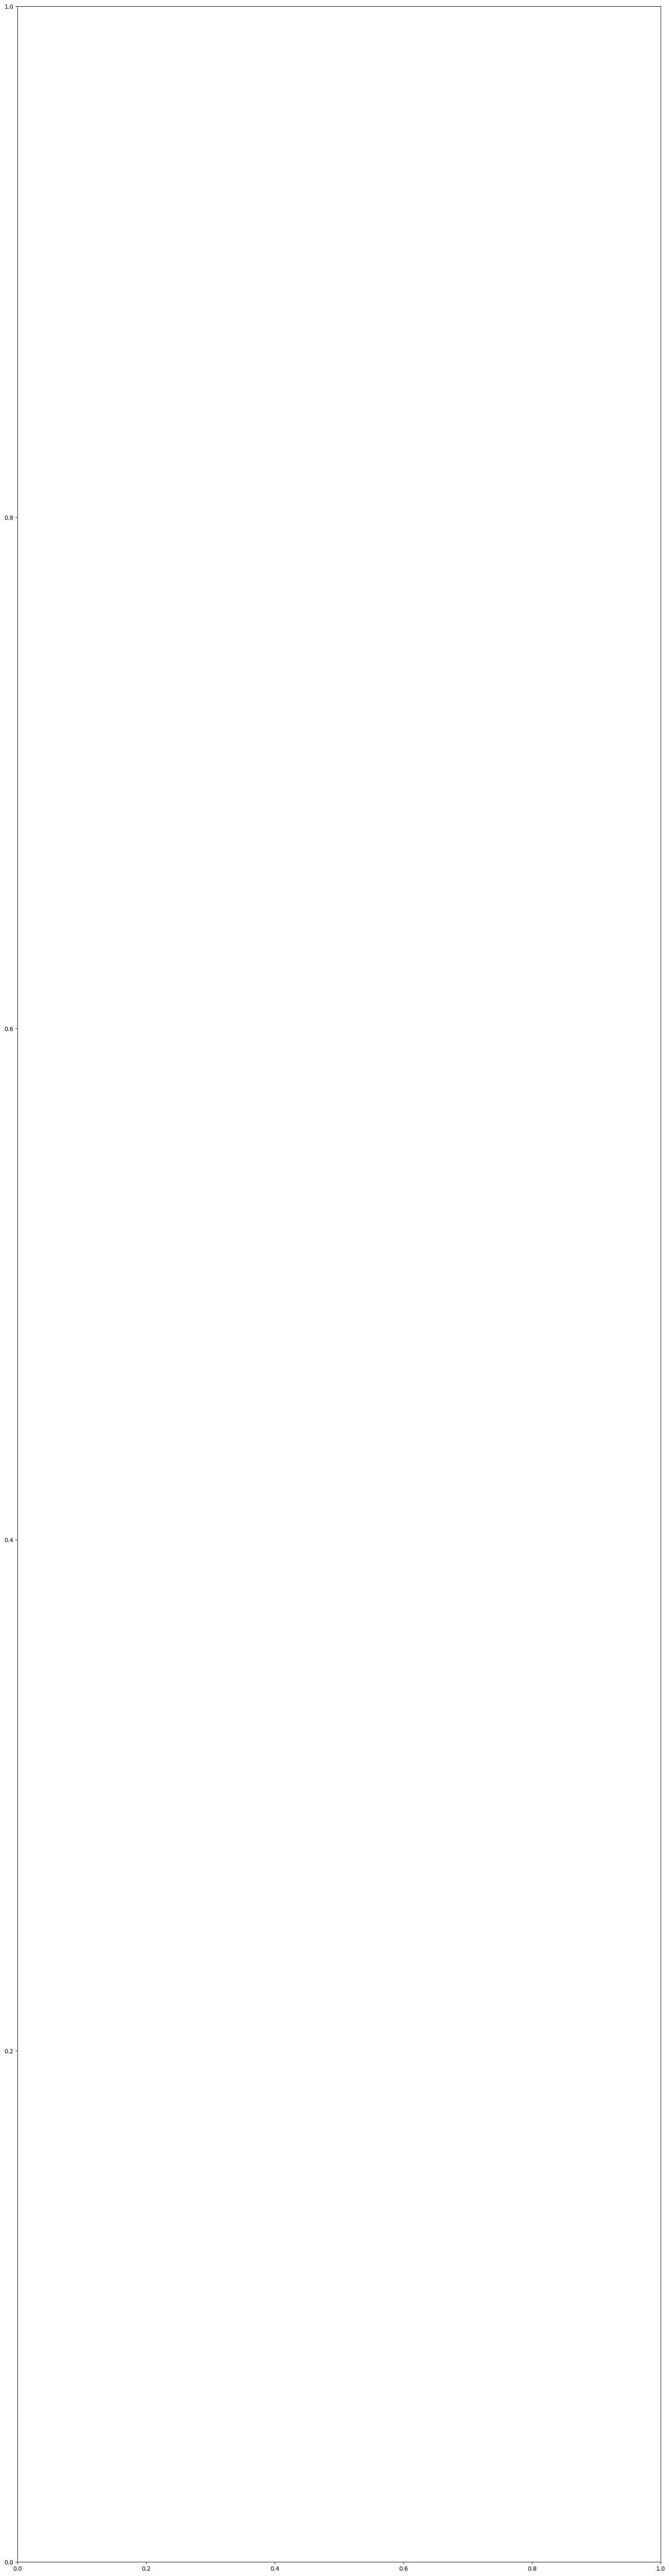

In [47]:
# import matplotlib.pyplot as plt

# Group the data by month
btcusdt_df['month'] = btcusdt_df['open_time'].dt.month
grouped_df = btcusdt_df.groupby('month')

btcusdt_df.month[-1] = 12

# Create subplots for each month
fig, axs = plt.subplots(len(grouped_df), figsize=(20, 80), sharex=False)

# Iterate over each month and plot the data
for i, (month, data) in enumerate(grouped_df):
    axs[i].plot(data['open_time'], data['close'])
    axs[i].set_title(f'Month {month}')
    # axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Close Price')
    
    # Add buy and sell signals
    for j in range(data.shape[0]):
        if data['Final_signal'].iloc[j] == ActionType.BUY:
            axs[i].text(data['open_time'].iloc[j], data['close'].iloc[j], 'BUY', color='g', fontsize=12, ha='center')
        elif data['Final_signal'].iloc[j] == ActionType.SELL:
            axs[i].text(data['open_time'].iloc[j], data['close'].iloc[j], 'SELL', color='r', fontsize=12, ha='center')

plt.tight_layout()
plt.show()

mean
sd
median
change precentage in the portfolio value

In [46]:
symbol = 'BTCUSDT'

avg_returns = btcusdt_df.ReturnsPct.mean()
std_returns = btcusdt_df.ReturnsPct.std()
total_returns = ((btcusdt_df.close.iloc[-1] - btcusdt_df.close.iloc[0]) / btcusdt_df.close.iloc[0])

info_string = f'''
        Returns Statistics for {symbol}:

        Average Returns: {avg_returns:.3%}
        Returns Standard Deviation: {std_returns:.3%}

        Total Returns:
            Total Returns from {btcusdt_df.open_time.iloc[0].strftime('%Y-%m-%d')} to {btcusdt_df.open_time.iloc[-1].strftime('%Y-%m-%d')}: {total_returns:.2%}
        {"-"*100}
        '''
print(info_string)


        Returns Statistics for BTCUSDT:

        Average Returns: 0.006%
        Returns Standard Deviation: 0.324%

        Total Returns:
            Total Returns from 2023-01-01 to 2024-01-01: 157.60%
        ----------------------------------------------------------------------------------------------------
        
